使用设备: cpu


Epoch 5/5: 100%|██████████| 938/938 [00:17<00:00, 55.15it/s, loss=0.145]   


测试准确率: 98.06%
模型已保存为 mnist_model.pth


/tmp/ipykernel_86524/3434464437.py:133: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_86524/3434464437.py:133: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_86524/3434464437.py:133: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_86524/3434464437.py:133: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_86524/3434464437.py:134: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.savefig('mnist_predictions.png')
/tmp/ipykernel_86524/3434464437.py:134: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig('mnist_predictions.png')
/tmp/ipykernel_86524/3434464437.py:134: UserWa

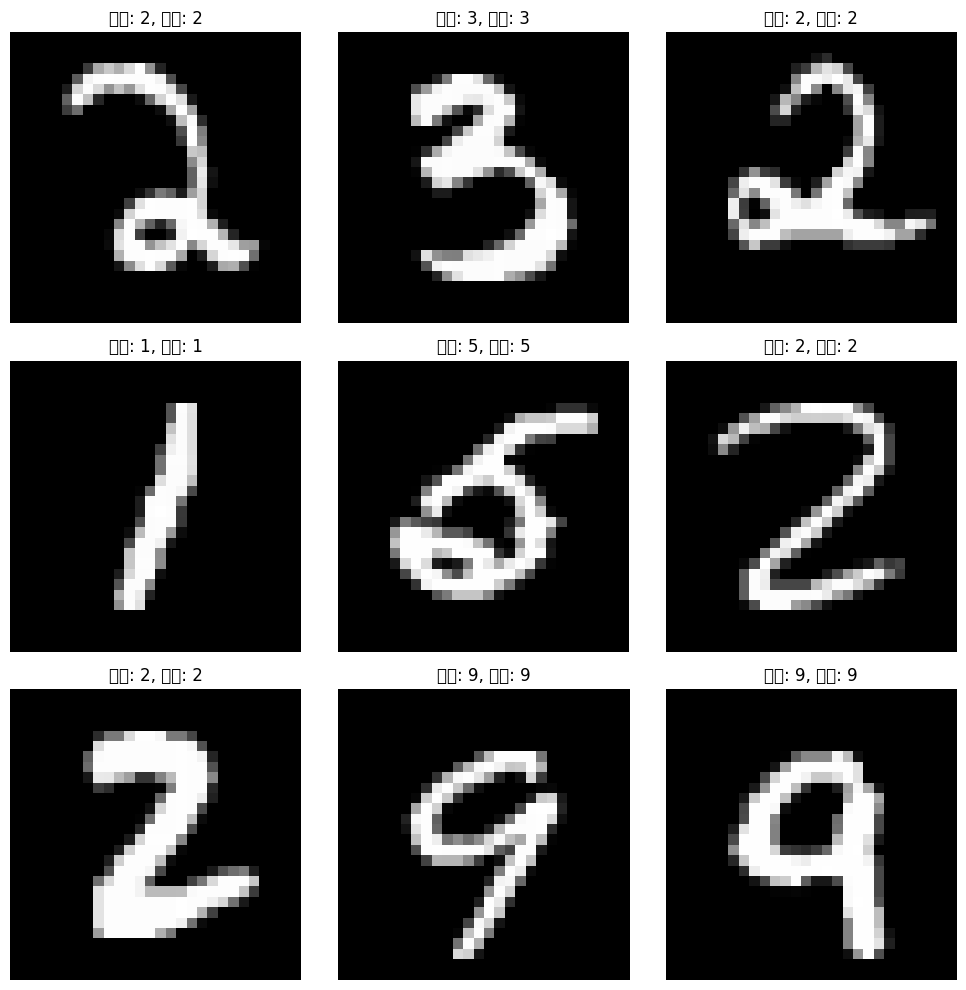

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# 1. 检查设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 2. 准备MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transform
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=64, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=64, 
    shuffle=False
)

# 3. 构建神经网络模型
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # 展平图像
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNet().to(device)

# 4. 配置损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. 训练函数
def train_model(epochs):
    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 更新进度条
            loop.set_postfix(loss=loss.item())

# 6. 测试函数
def test_model():
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"测试准确率: {accuracy:.2f}%")
    return accuracy

# 7. 执行训练和测试
if __name__ == "__main__":
    train_model(epochs=5)
    accuracy = test_model()
    
    # 保存模型
    torch.save(model.state_dict(), "mnist_model.pth")
    print("模型已保存为 mnist_model.pth")

    # 随机选择9个测试样本可视化
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for i in range(9):
        idx = np.random.randint(0, len(test_dataset))
        image, label = test_dataset[idx]
        image = image.to(device)
        
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            _, prediction = torch.max(output, 1)
        
        ax = axes[i//3, i%3]
        ax.imshow(image.squeeze().cpu().numpy(), cmap='gray')
        ax.set_title(f"真实: {label}, 预测: {prediction.item()}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('mnist_predictions.png')
    plt.show()